In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.2 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import joblib

In [4]:
DATA_PATH = "/content/drive/MyDrive/SEM 7/ML/UAP/synthetic_disaster_events_2025.csv"
SAVE_PATH = "/content/drive/MyDrive/SEM 7/ML/UAP/"
os.makedirs(SAVE_PATH, exist_ok=True)

# Load CSV asli
df = pd.read_csv(DATA_PATH)

# Buat copy untuk training, drop kolom yang tidak dipakai dalam model
# is_major_disaster tetap ada di df asli (untuk input form/batch nanti), tapi diabaikan di training
df_train = df.drop(columns=["event_id", "date", "is_major_disaster"])

In [5]:
def classify_disaster(row):
    score = 0
    if row["severity_level"] >= 7:
        score += 2
    elif row["severity_level"] >= 4:
        score += 1
    if row["affected_population"] >= 50000:
        score += 2
    elif row["affected_population"] >= 10000:
        score += 1
    if row["estimated_economic_loss_usd"] >= 5_000_000:
        score += 2
    elif row["estimated_economic_loss_usd"] >= 1_000_000:
        score += 1
    if row["infrastructure_damage_index"] >= 0.6:
        score += 2
    elif row["infrastructure_damage_index"] >= 0.3:
        score += 1
    if score >= 6:
        return 2  # Severe
    elif score >= 3:
        return 1  # Moderate
    else:
        return 0  # Minor

df_train["disaster_severity_class"] = df_train.apply(classify_disaster, axis=1)

In [6]:
cat_cols = ["disaster_type", "location", "aid_provided"]
num_cols = [c for c in df_train.columns if c not in cat_cols + ["disaster_severity_class"]]

# Label Encoding untuk kategorikal
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    label_encoders[col] = le

# Pisah X dan y
X = df_train.drop(columns=["disaster_severity_class"])
y = df_train["disaster_severity_class"]

# Scaling numerik
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

# Simpan scaler dan encoder untuk inference
joblib.dump(scaler, SAVE_PATH + "scaler.pkl")
joblib.dump(label_encoders, SAVE_PATH + "label_encoders.pkl")

Train: (14000, 10)
Val: (3000, 10)
Test: (3000, 10)


['/content/drive/MyDrive/SEM 7/ML/UAP/label_encoders.pkl']

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6969 - loss: 0.6580 - val_accuracy: 0.8887 - val_loss: 0.2685
Epoch 2/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8724 - loss: 0.2932 - val_accuracy: 0.9050 - val_loss: 0.2358
Epoch 3/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8888 - loss: 0.2602 - val_accuracy: 0.9097 - val_loss: 0.2210
Epoch 4/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8953 - loss: 0.2426 - val_accuracy: 0.9130 - val_loss: 0.2137
Epoch 5/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9028 - loss: 0.2246 - val_accuracy: 0.9120 - val_loss: 0.2030
Epoch 6/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8995 - loss: 0.2274 - val_accuracy: 0.9173 - val_loss: 0.2007
Epoch 7/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9114 - loss: 0.2099 - val_accuracy: 0.9170 - val_loss: 0.1946
Epoch 8/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9186 - loss: 0.2002 - val_accuracy: 

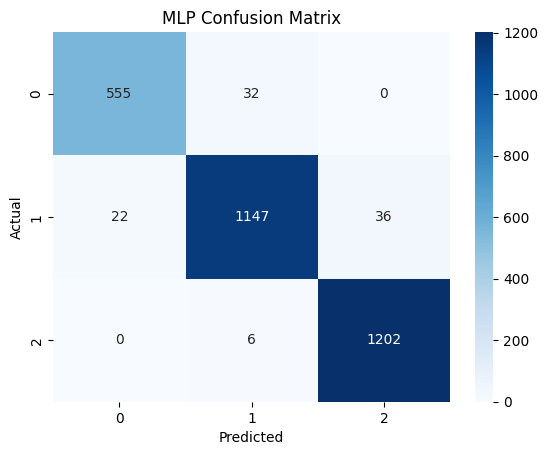

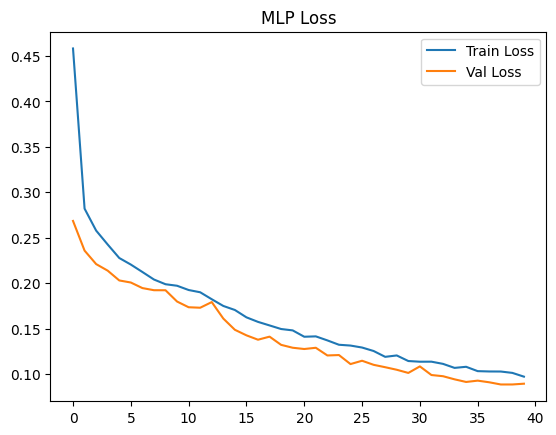

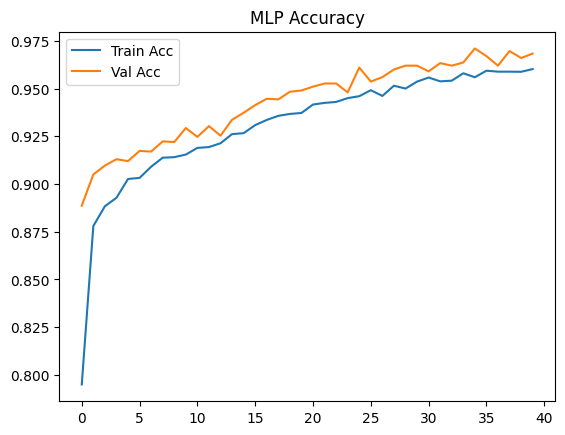

In [7]:
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

mlp = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")
])

mlp.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history_mlp = mlp.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
class_names = ["Minor", "Moderate", "Severe"]
y_pred_mlp = np.argmax(mlp.predict(X_test), axis=1)
print("MLP Classification Report:")
print(classification_report(y_test, y_pred_mlp, target_names=class_names))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt="d", cmap="Blues")
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot Loss & Accuracy
plt.plot(history_mlp.history["loss"], label="Train Loss")
plt.plot(history_mlp.history["val_loss"], label="Val Loss")
plt.title("MLP Loss")
plt.legend()
plt.show()

plt.plot(history_mlp.history["accuracy"], label="Train Acc")
plt.plot(history_mlp.history["val_accuracy"], label="Val Acc")
plt.title("MLP Accuracy")
plt.legend()
plt.show()

mlp.save(SAVE_PATH + "mlp_disaster_model.keras")

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70118 | train_accuracy: 0.79664 | train_logloss: 0.5557  | valid_accuracy: 0.786   | valid_logloss: 0.55352 |  0:00:02s
epoch 10 | loss: 0.1778  | train_accuracy: 0.93864 | train_logloss: 0.14624 | valid_accuracy: 0.936   | valid_logloss: 0.16064 |  0:00:14s
epoch 20 | loss: 0.11908 | train_accuracy: 0.96421 | train_logloss: 0.09914 | valid_accuracy: 0.959   | valid_logloss: 0.1085  |  0:00:26s
epoch 30 | loss: 0.09508 | train_accuracy: 0.97393 | train_logloss: 0.06619 | valid_accuracy: 0.97533 | valid_logloss: 0.07198 |  0:00:40s
epoch 40 | loss: 0.12555 | train_accuracy: 0.97343 | train_logloss: 0.07859 | valid_accuracy: 0.96933 | valid_logloss: 0.08852 |  0:00:52s
epoch 50 | loss: 0.10312 | train_accuracy: 0.97371 | train_logloss: 0.06864 | valid_accuracy: 0.97333 | valid_logloss: 0.07567 |  0:01:05s
epoch 60 | loss: 0.08424 | train_accuracy: 0.97964 | train_logloss: 0.05679 | valid_accuracy: 0.975   | valid_logloss: 0.06842 |  0:01:17s
epoch 70 | loss: 0.08439 | 

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Classification Report:
              precision    recall  f1-score   support

       Minor       1.00      0.98      0.99       587
    Moderate       0.98      1.00      0.99      1205
      Severe       1.00      1.00      1.00      1208

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



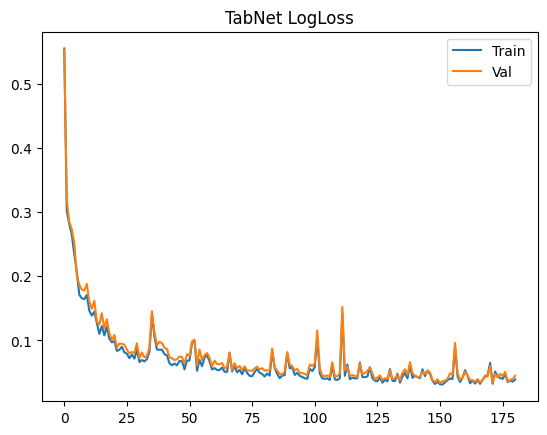

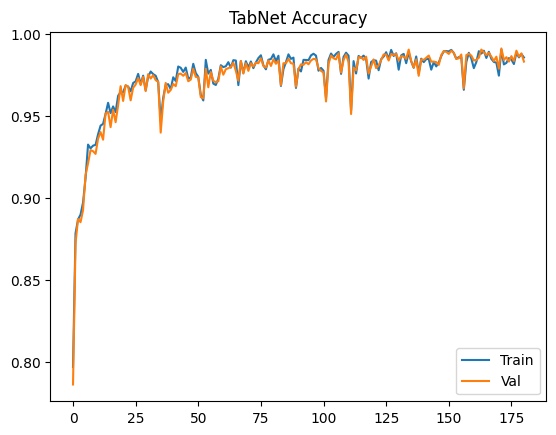

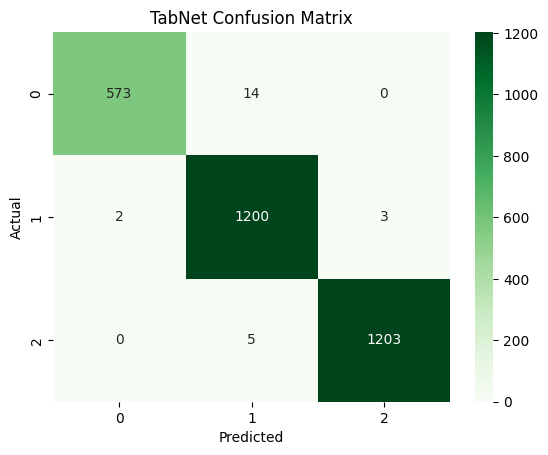

Successfully saved model at /content/drive/MyDrive/SEM 7/ML/UAP/tabnet_disaster_model.zip


'/content/drive/MyDrive/SEM 7/ML/UAP/tabnet_disaster_model.zip'

In [8]:
tabnet = TabNetClassifier(
    n_d=16, n_a=16, n_steps=5, gamma=1.5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    verbose=10
)

tabnet.fit(
    X_train.values, y_train.values,
    eval_set=[(X_train.values, y_train.values), (X_val.values, y_val.values)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy", "logloss"],
    max_epochs=200,
    patience=30,
    batch_size=1024,
    virtual_batch_size=128
)

# Evaluasi TabNet
y_pred_tabnet = tabnet.predict(X_test.values)
print("TabNet Classification Report:")
print(classification_report(y_test, y_pred_tabnet, target_names=class_names))

# Plot LogLoss & Accuracy
plt.plot(tabnet.history["train_logloss"], label="Train")
plt.plot(tabnet.history["valid_logloss"], label="Val")
plt.title("TabNet LogLoss")
plt.legend()
plt.show()

plt.plot(tabnet.history["train_accuracy"], label="Train")
plt.plot(tabnet.history["valid_accuracy"], label="Val")
plt.title("TabNet Accuracy")
plt.legend()
plt.show()

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_tabnet), annot=True, fmt="d", cmap="Greens")
plt.title("TabNet Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

tabnet.save_model(SAVE_PATH + "tabnet_disaster_model")

Epoch 1/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7739 - loss: 0.5576 - val_accuracy: 0.9047 - val_loss: 0.2252
Epoch 2/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8975 - loss: 0.2338 - val_accuracy: 0.9157 - val_loss: 0.2145
Epoch 3/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9021 - loss: 0.2194 - val_accuracy: 0.9170 - val_loss: 0.1953
Epoch 4/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9133 - loss: 0.2026 - val_accuracy: 0.9220 - val_loss: 0.1846
Epoch 5/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9147 - loss: 0.1965 - val_accuracy: 0.9230 - val_loss: 0.1839
Epoch 6/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9194 - loss: 0.1914 - val_accuracy: 0.9273 - val_loss: 0.1748
Epoch 7/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9197 - loss: 0.1839 - val_accuracy: 0.9283 - val_loss: 0.1733
Epoch 8/200
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9247 - loss: 0.1759 - val_ac

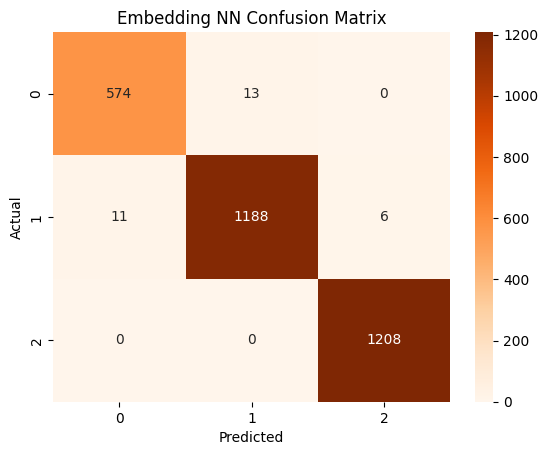

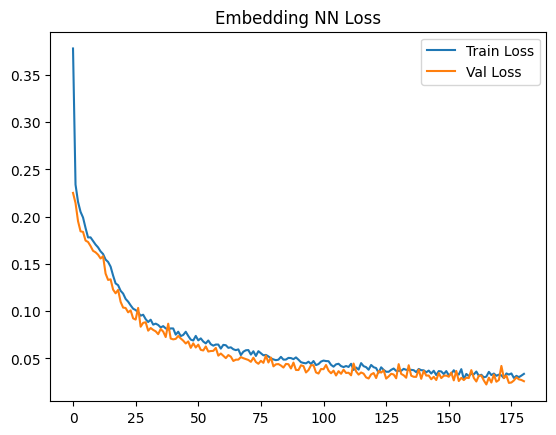

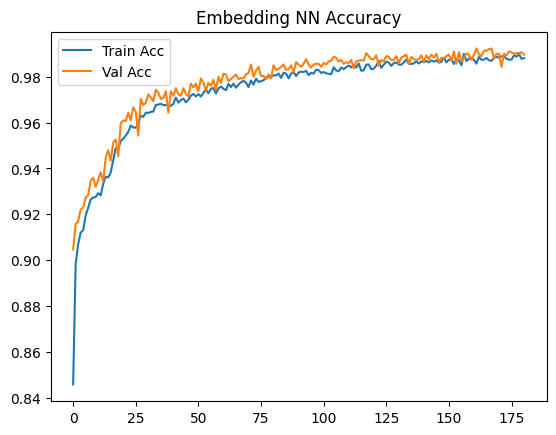

In [9]:
# Input untuk embedding
inputs, embeddings = [], []
for col in cat_cols:
    inp = Input(shape=(1,), name=col)
    emb = Embedding(df_train[col].nunique() + 1, 8)(inp)
    emb = Flatten()(emb)
    inputs.append(inp)
    embeddings.append(emb)

num_input = Input(shape=(len(num_cols),), name="numerical")
inputs.append(num_input)
x = Concatenate()(embeddings + [num_input])
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
out = Dense(3, activation="softmax")(x)

embedding_model = Model(inputs, out)
embedding_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Siapkan data untuk embedding model
X_train_embed = [X_train[col].values for col in cat_cols] + [X_train[num_cols].values]
X_val_embed = [X_val[col].values for col in cat_cols] + [X_val[num_cols].values]
X_test_embed = [X_test[col].values for col in cat_cols] + [X_test[num_cols].values]

history_embed = embedding_model.fit(
    X_train_embed, y_train,
    validation_data=(X_val_embed, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
y_pred_embed = np.argmax(embedding_model.predict(X_test_embed), axis=1)
print("Embedding NN Classification Report:")
print(classification_report(y_test, y_pred_embed, target_names=class_names))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_embed), annot=True, fmt="d", cmap="Oranges")
plt.title("Embedding NN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot Loss & Accuracy
plt.plot(history_embed.history["loss"], label="Train Loss")
plt.plot(history_embed.history["val_loss"], label="Val Loss")
plt.title("Embedding NN Loss")
plt.legend()
plt.show()

plt.plot(history_embed.history["accuracy"], label="Train Acc")
plt.plot(history_embed.history["val_accuracy"], label="Val Acc")
plt.title("Embedding NN Accuracy")
plt.legend()
plt.show()

embedding_model.save(SAVE_PATH + "embedding_nn_disaster_model.keras")